<a href="https://colab.research.google.com/github/nin-ed/Linear-Regression-Vs-Bayesian-Regression/blob/main/LinearRegVSBayesianReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.distributions.multivariate_normal import MultivariateNormal
from sklearn.linear_model import LinearRegression
from numpy.linalg import inv

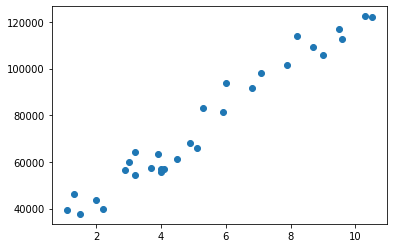

In [2]:
data = pd.read_csv("/content/drive/My Drive/salary_data.csv").values
x = np.array(data[:, 0]).reshape(-1, 1)
y = np.array(data[:, 1]).reshape(-1, 1)

plt.scatter(x, y)

## Reference: Linear Regression by Scikit Learn

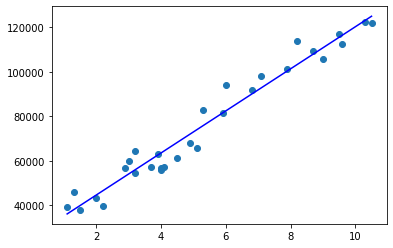

In [3]:
lr = LinearRegression()
lr.fit(x, y)
pred = lr.predict(x)
plt.scatter(x, y)
plt.plot(x, pred, color="b")

## Linear Regression using ANN

In [4]:
class Network(nn.Module):
    def __init__(self, inc, outc):
        super(Network, self).__init__()
        self.inp = nn.Linear(inc, outc)

    def forward(self, x):
        x = self.inp(x)
        return x

model = Network(1, 1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
epoch = 2694

In [5]:
for e in range(epoch):
    optimizer.zero_grad()
    output = model.forward(torch.Tensor(x))
    loss = criterion(output, torch.Tensor(y))
    loss.backward()
    optimizer.step()

with torch.no_grad():
    ap = model.forward(torch.Tensor(x))

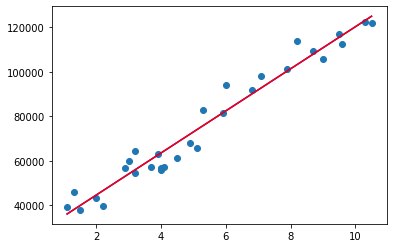

In [6]:
plt.scatter(x, y)
plt.plot(x, pred, color="b")
plt.plot(x, ap, color="r")

In [7]:
[w, b] = model.parameters()
print(w, b)
print(criterion(torch.Tensor(pred), ap))

Parameter containing:
tensor([[9449.9980]], requires_grad=True) Parameter containing:
tensor([25791.9609], requires_grad=True)
tensor(0.0125)


## Bayesian Regression

p(w|y,X) proportional to p(y|w,X).p(w|X)

Initial:

p(w) = Normal(w;0, 1/a * I)

p(y|w,X) = Normal(y;wx,var)

cov = inv(inv(cov0) + inv(var) * X * X)
mean = inv(cov) * (inv(cov0) * mean0 + inv(var) * X * y)

In [8]:
def x_mat(x, prior_mean):
  mat = np.ones((len(x), len(prior_mean)))
  for i in range(len(x)):
    mat[i, 1] = x[i]
  return mat

In [9]:
def prior_update(x, y, prior_cov, prior_mean, prior_distr, beta):
  mat = x_mat(x, prior_mean)
  post_cov = inv(inv(prior_cov) + beta * np.dot(mat.T, mat))
  post_mean = np.dot(post_cov, np.dot(inv(prior_cov), prior_mean) + beta * np.dot(mat.T, y))
  post_distr = MultivariateNormal(loc=torch.Tensor(post_mean), covariance_matrix=torch.Tensor(prior_cov))
  prior_mean = post_mean
  prior_cov = post_cov
  prior_distr = post_distr
  return prior_mean, prior_cov, prior_distr, post_distr

In [10]:
def predict(X, prior_cov, prior_mean):
  mat = x_mat(X, prior_mean)
  pred = []
  for i in range(len(mat)):
      x = mat[i, :]
      pred_cov = 1 / beta + np.dot(x.T, np.dot(prior_cov, x))
      pred_mean = np.dot(prior_mean, x)
      pred.append(pred_mean)
  return pred

In [11]:
alpha = 2
beta = 25
prior_mean = np.zeros(2)
prior_cov = 1 / alpha * np.eye(2)
prior_distr = MultivariateNormal(loc=torch.Tensor(prior_mean), covariance_matrix=torch.Tensor(prior_cov))
global post_distr

for i in range(len(x)):
  prior_mean, prior_cov, prior_distr, post_distr = prior_update(x[i], y[i], prior_cov, prior_mean, prior_distr, beta)

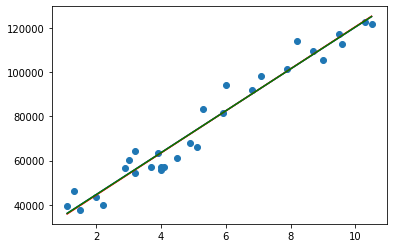

In [12]:
bp = predict(x, prior_cov, prior_mean)
plt.scatter(x, y)
plt.plot(x, pred, color="b")
plt.plot(x, bp, color="r")
plt.plot(x, ap, color="g")